In [0]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from string import punctuation
import re
import tweepy
import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

## Task A. 
Collect 5k tweets on the 2020 Presidential election. It is necessary to use general hashtags and search keywords (like 2020 U.S. election or 2020 Presidential Election) rather than “Trump” or “Biden” or “Warren”. Use Tweepy in your Python script, and also ask for the location specified by the user during registration with Twitter. 

The tweets have already been scraped and thus the script below does not need to be run again.

In [0]:
#First and foremost scraping the tweets using tweepy

file = open(r"secrets.txt","r")
secrets = file.read().split('\n')

# consumer keys and access tokens, used for OAuth
consumer_key = secrets[0]
consumer_secret = secrets[1]
access_token = secrets[2]
access_token_secret = secrets[3]
 
# Application only Auth
auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)

# creation of the actual interface, using authentication
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)

In [0]:
num = 5000 # how many tweets we want
max_num_per_call = 500 # max allowed for one request

allTweets = []
filteredTweets = []
justTweets = []

# initial request test tweet
electionTweets = tweepy.Cursor(api.search, q="2020 election | US election", result_type="mixed", lang="en").items(max_num_per_call)

# save the tweet
allTweets.extend(electionTweets)
   
for tweet in allTweets:   
    if tweet.text not in justTweets: # don't add duplicate tweets
        text = tweet.text
        location = tweet.user.location
        justTweets.append(tweet.text)
        filteredTweets.append({
                        'tweet':text,
                        'location':location})

    
# save the id of the tweet less one
oldest = allTweets[-1].id - 1 

while len(filteredTweets) < num:

    # call search API with election keywords
    electionTweets = tweepy.Cursor(api.search, q="2020 election | US election", result_type="mixed", lang="en", max_id=oldest).items(max_num_per_call)

    #save most recent tweets
    allTweets.extend(electionTweets)

    for tweet in allTweets:
        if tweet.text not in justTweets: # don't add duplicate tweets
        text = tweet.text
        location = tweet.user.location
        justTweets.append(tweet.text)
        filteredTweets.append({
                        'tweet':text,
                        'location':location})

    #save the id of the oldest tweet less one
    oldest = allTweets[-1].id - 1
    
    tweetDate = allTweets[-1].created_at
    
    print(f"{len(filteredTweets)} tweets downloaded so far")
    print("since: "f"{tweetDate}")
        

In [0]:
filtered = pd.DataFrame(filteredTweets, columns=['tweet','location'])
filtered.tail()
df_tweets.to_csv('filtered_tweets.csv')

## Task B. 
Find FOUR key issues mentioned by the public in the tweets – e.g., character, personality, healthcare, crime, jobs, etc. (these are examples only, use word frequency analysis to find out). Replace words if necessary. Issues associated with Mr. Trump may not have a strong association with the democratic candidate and vice versa. So find a couple of issues that are likely to have strong association with Mr. Trump, and a couple for the democratic candidate.

In [0]:
## Loading the scraped data into a dataframe.
tweets = pd.read_csv("filtered_tweets_6000.csv")
tweets.drop(columns=['Unnamed: 0'],inplace=True)

## Also loading the word replacement file which has all the replacements to be made into a dataframe
## e.g. trump, donald, realdonaldtrump with "trump"
df_replacements = pd.read_excel("Word_Replace-3.xlsx")
df_replacements.head()

,replacement,word
0,trump,realdonaldtrump
1,trump,donald
2,trump,potus
3,biden,joe
4,biden,joebiden


In [0]:
location_only = tweets['location']
flitered_tweets = pd.DataFrame(location_only, columns=['location'])
flitered_tweets.head()

,location
0,"Washington, DC"
1,"Uppsala, Sweden"
2,United States of America
3,Rockies
4,NaN


In [0]:
## Libraries for Tokenizer and Stopwords

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rutwi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rutwi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
## Cleaning the Tweets and get the WordCount

master_list = []
i =0
for comment in tweets['tweet']:
    
    #break sentence to words
    words = word_tokenize(str(comment))
    
    #Lower case
    words = [word.lower() for word in words]
    
    #Remove single-character tokens (mostly punctuation)
    words = [word for word in words if len(word) > 1]
  
    #Remove special character sequences like ...,''''''
    words = [word for word in words if word.isalnum()]
    
    #Replace words
    for word in words:
        my_word = re.sub('[^a-zA-Z0-9 \n\.]', '', word)
        if my_word in df_replacements['word'].values:
            words[words.index(word)] = df_replacements[df_replacements['word']==word]['replacement'].values[0] 
      
    #Remove numbers
    words = [word for word in words if not word.isnumeric()]
    
    #Remove duplicates (we want to count frequency of a word as 1 even if it has been used more than once in a single comment)
    unique_words = []
    [unique_words.append(word) for word in words if word not in unique_words]   
    
    #Remove stop words
    stop_words=set(stopwords.words("english"))
    filtered_words = []
    for word in unique_words:
        if word not in stop_words:
            filtered_words.append(word)
    
    master_list.extend(filtered_words)
    flitered_tweets.loc[i,'Filtered_Tweet'] = ' '.join(filtered_words)
    i=i+1
wordfreq = FreqDist(master_list)
wordfreq

FreqDist({'https': 3649, 'rt': 2953, 'election': 2339, 'us': 2060, 'trump': 1911, 'democrat': 943, 'gabbard': 746, 'russia': 543, 'presidential': 467, 'amp': 463, ...})

In [0]:
## Saving the WordCount into a DataFrame with two columns - Word and Count
## Then Saving the DataFrame to a csv file

wordfreq_df = pd.DataFrame(wordfreq.most_common(), columns =['Word', 'Count']) 
wordfreq_df.to_csv('wordfreq_tweets_latest.csv')

In [0]:
## Saving the cleaned tweets in a new csv file
flitered_tweets['Filtered_Tweet'].to_csv('wordfreq_tweets_latest_filtered.csv')
flitered_tweets.head()
taskedf = flitered_tweets.copy()

## Adding a new column "combined" with location and tweet combined
taskedf['combined'] = taskedf['location'] + " " + taskedf['Filtered_Tweet']
taskedf

C:\Users\rutwi\Anaconda_3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


,location,Filtered_Tweet,combined
0,"Washington, DC",poll shows trump corygardner unpopular colorad...,"Washington, DC poll shows trump corygardner un..."
1,"Uppsala, Sweden",hillary clinton mentioned anyone name gabbard ...,"Uppsala, Sweden hillary clinton mentioned anyo..."
2,United States of America,texas republicans complaining secret could los...,United States of America texas republicans com...
3,Rockies,rt johnlundin gabbard criticism hilary warning...,Rockies rt johnlundin gabbard criticism hilary...
4,NaN,rt danasaurusrex93 listen ninaturner election ...,NaN
5,USA,rt libertea2012 gabbard says hillary clinton c...,USA rt libertea2012 gabbard says hillary clint...
6,Chicagoland,rt zeusfanhouse trump texas left wants install...,Chicagoland rt zeusfanhouse trump texas left w...
7,Somewhere on earth,rt ashoswai hillary clinton mentioned anyone n...,Somewhere on earth rt ashoswai hillary clinton...
8,Rhode Island,rt heart hearts us election would kamalaharris...,Rhode Island rt heart hearts us election would...
9,Washington DC area,rt mmpadellan hillary clinton already warned u...,Washington DC area rt mmpadellan hillary clint...


<b>Note: We have decided to go with an extra democratic candidate: Congresswoman Tulsi Gabbard. Many of our tweets were scraped during the weekend October 19-20. During this time, there was a war of words between Senator Hillary Clinton and Gabbard which led to Gabbard trending in the news for a couple of days. Thus, Gabbard  appeared as the most frequently mentioned democratic candidate. Taking this short term spike in popularity into account, we have included her as well as Biden, who was the second most mentioned candidate.</b>

In [0]:
## Loading the Top 4 issues and Top 3 candidates

top4issues_df = pd.read_csv("issues.csv")
top4issues = top4issues_df.values.tolist()
print("Top 4 issues : ")
print(top4issues)
top2candidates = [['Trump',wordfreq_df[wordfreq_df['Word']=='trump']['Count'].values[0]],['Biden',wordfreq_df[wordfreq_df['Word']=='biden']['Count'].values[0]],['Gabbard',wordfreq_df[wordfreq_df['Word']=='gabbard']['Count'].values[0]]]
print("\nTop 3 candidates : ")
print(top2candidates)
print("\nFor the next parts of our assignment we have chosen 3 candidates and not just 2. We have modified the calculations accordingly.")

Top 4 issues : 
[['Russia', 543], ['War', 335], ['Economy', 237], ['Interference', 159]]

Top 3 candidates : 
[['Trump', 1911], ['Biden', 396], ['Gabbard', 746]]

For the next parts of our assignment we have chosen 3 candidates and not just 2. We have modified the calculations accordingly.


## Task C. 
Perform lift and sentiment analysis on a candidate and an issue:

In [0]:
### Lift calculations between Issues and candidates (4 * 3)

issue_candidate = {}

for i in range(len(top4issues)): ## 4 issues
    for j in range(len(top2candidates)): ## 3 candidates
        issue_candidate[(top4issues[i][0],top2candidates[j][0])] = 0


for filtered_tweet in flitered_tweets['Filtered_Tweet']:   
    ## Counting the frequency of issue-candidate pairs
    for key in issue_candidate.keys():
        if (key[0].lower() in filtered_tweet and key[1].lower() in filtered_tweet):
           issue_candidate[key] += 1
    
print(issue_candidate)
print("\n")

### Lift analysis for Issue Pairs

lift_analysis = {}
for key in issue_candidate.keys():
   numerator = issue_candidate[key]
   denominator = dict(top4issues)[key[0]] * dict(top2candidates)[key[1]]
   lift_value = (numerator/denominator)*len(flitered_tweets)
   lift_analysis[key] = lift_value
print(lift_analysis)

{('Russia', 'Trump'): 241, ('Russia', 'Biden'): 1, ('Russia', 'Gabbard'): 302, ('War', 'Trump'): 361, ('War', 'Biden'): 79, ('War', 'Gabbard'): 303, ('Economy', 'Trump'): 215, ('Economy', 'Biden'): 0, ('Economy', 'Gabbard'): 0, ('Interference', 'Trump'): 16, ('Interference', 'Biden'): 0, ('Interference', 'Gabbard'): 4}


{('Russia', 'Trump'): 1.4678227148629674, ('Russia', 'Biden'): 0.029391521104228286, ('Russia', 'Gabbard'): 4.711783903347009, ('War', 'Trump'): 3.5638448261049542, ('War', 'Biden'): 3.7636062113674056, ('War', 'Gabbard'): 7.66259853547277, ('Economy', 'Trump'): 3.0001744287458574, ('Economy', 'Biden'): 0.0, ('Economy', 'Gabbard'): 0.0, ('Interference', 'Trump'): 0.33279688266211177, ('Interference', 'Biden'): 0.0, ('Interference', 'Gabbard'): 0.21312829851450923}


In [0]:
### Lift calculations between all Issues and candidates (7*7)
### This will be used for MDS plotting

lift = top4issues.copy()
lift.extend(top2candidates)

issue_candidate_all = {}

for i in range(len(lift)): ## 4 issues
    for j in range(len(lift)): ## 2 candidates
        issue_candidate_all[(lift[i][0],lift[j][0])] = 0


for filtered_tweet in flitered_tweets['Filtered_Tweet']:   
    ## Counting the frequency of issue-candidate pairs
    for key in issue_candidate_all.keys():
        if (key[0].lower() in filtered_tweet and key[1].lower() in filtered_tweet):
            issue_candidate_all[key] += 1
    

print(issue_candidate_all)
print("\n")

### Lift analysis for all issue candidate Pairs

lift_analysis_all = {}
for key in issue_candidate_all.keys():
   numerator = issue_candidate_all[key]
   denominator = dict(lift)[key[0]] * dict(lift)[key[1]]
   lift_value = (numerator/denominator)*len(flitered_tweets)
   lift_analysis_all[key] = lift_value
print(lift_analysis_all)


{('Russia', 'Russia'): 576, ('Russia', 'War'): 275, ('Russia', 'Economy'): 0, ('Russia', 'Interference'): 17, ('Russia', 'Trump'): 241, ('Russia', 'Biden'): 1, ('Russia', 'Gabbard'): 302, ('War', 'Russia'): 275, ('War', 'War'): 895, ('War', 'Economy'): 0, ('War', 'Interference'): 1, ('War', 'Trump'): 361, ('War', 'Biden'): 79, ('War', 'Gabbard'): 303, ('Economy', 'Russia'): 0, ('Economy', 'War'): 0, ('Economy', 'Economy'): 237, ('Economy', 'Interference'): 0, ('Economy', 'Trump'): 215, ('Economy', 'Biden'): 0, ('Economy', 'Gabbard'): 0, ('Interference', 'Russia'): 17, ('Interference', 'War'): 1, ('Interference', 'Economy'): 0, ('Interference', 'Interference'): 161, ('Interference', 'Trump'): 16, ('Interference', 'Biden'): 0, ('Interference', 'Gabbard'): 4, ('Trump', 'Russia'): 241, ('Trump', 'War'): 361, ('Trump', 'Economy'): 215, ('Trump', 'Interference'): 16, ('Trump', 'Trump'): 2141, ('Trump', 'Biden'): 84, ('Trump', 'Gabbard'): 186, ('Biden', 'Russia'): 1, ('Biden', 'War'): 79, ('B

In [0]:
# Creating a dictionary with all issue and candidate pair
tweet_issue_candidate = {}

for i in range(len(top4issues)): ## 4 issues
    for j in range(len(top2candidates)): ## 3 candidates
        tweet_issue_candidate[(top4issues[i][0],top2candidates[j][0])] = 0

To isolate a candidate and an issue, you have to write a parser that selects tweets that mention a candidate, takes a window around an issue, and chops off everything else, as shown in class.  

In [0]:
# Creating a dataframe to store all issue , candidate , tweet that mentions both issue and candidate
## and chopped tweet that takes a window around an issue
tweet_issue_candidate_df = pd.DataFrame(columns = ['issue', 'candidate','tweet','chopped_tweet'],index=None)     

i = 0
for tweet in flitered_tweets['Filtered_Tweet']:
    for key in tweet_issue_candidate.keys():
        if key[0].lower() in tweet.split() and key[1].lower() in tweet.split():
            tweet_issue_candidate_df.loc[i] = [key[0],key[1],tweet,'']
            i+=1

In [0]:
# Function to get a window around an issue(3 words to left and 3 words to the right of the issue)
def search(tweet,issue):
    words = re.findall(r'\w+', tweet)
    index = words.index(issue)
    tweet_length = len(words)
    if index + 4 <= tweet_length and index - 3 >= 0:
        left_phrase = ' '.join(words[index - 3:index])
        right_phrase = ' '.join(words[index + 1:index + 4])
        chopped_tweet = left_phrase + ' '+ issue +' '+ right_phrase
        return chopped_tweet
    elif index == 0 and index + 4 <= tweet_length :
        right_phrase = ' '.join(words[index + 1:index + 4])
        chopped_tweet = issue +' '+ right_phrase
        return chopped_tweet
    elif index == 1 and index + 4 <= tweet_length :
        left_phrase = ' '.join(words[index - 1:index])
        right_phrase = ' '.join(words[index + 1:index + 4])
        chopped_tweet = left_phrase + ' '+ issue +' '+ right_phrase
        return chopped_tweet
    elif index == 2 and index + 4 <= tweet_length :
        left_phrase = ' '.join(words[index - 2:index])
        right_phrase = ' '.join(words[index + 1:index + 4])
        chopped_tweet = left_phrase + ' '+ issue +' '+ right_phrase
        return chopped_tweet
    elif index == tweet_length - 1:
        left_phrase = ' '.join(words[index - 3:index])
        chopped_tweet = left_phrase+ ' '+ issue
        return chopped_tweet
    elif index == tweet_length - 2:
        left_phrase = ' '.join(words[index - 3:index])
        right_phrase = ' '.join(words[index + 1:tweet_length])
        chopped_tweet = left_phrase + ' '+ issue +' '+ right_phrase
        return chopped_tweet
    elif index == tweet_length - 3:
        left_phrase = ' '.join(words[index - 3:index])
        right_phrase = ' '.join(words[index + 1:tweet_length])
        chopped_tweet = left_phrase + ' '+ issue +' '+ right_phrase
        return chopped_tweet   
    else:
        return tweet

for index,rows in tweet_issue_candidate_df.iterrows():
    issue = rows['issue']
    tweet = rows['tweet']
    tweet_issue_candidate_df.loc[index]['chopped_tweet'] = search(tweet,issue.lower())

In [0]:
tweet_issue_candidate_df.head()

,issue,candidate,tweet,chopped_tweet
0,Russia,Gabbard,rt johnlundin gabbard criticism hilary warning...,confirm white nationalists russia
1,Russia,Trump,rt mmpadellan hillary clinton already warned u...,warned us trump russia puppet true warns
2,Russia,Gabbard,rt mmpadellan hillary clinton already warned u...,warned us trump russia puppet true warns
3,Russia,Trump,rt caslernoel trump freed thousands isis fight...,us troops panic russia
4,Russia,Trump,clear russia election trump clinton biden comm...,clear russia election trump clinton


In [0]:
# Creating a copy of the dataframe with additional columns to capture sentiment score
# We have calculated sentiment score of the full tweet as well as the chopped tweet
# full tweet columns =  ['sentiment_score_fulltweet','sentiment_fulltweet']
# chopped tweet columns = ['overall_sentiment','sentiment_score']

tweet_issue_candidate_sentiment_df = \
tweet_issue_candidate_df.assign(overall_sentiment="",sentiment_score="",sentiment_score_fulltweet="",sentiment_fulltweet="")

In [0]:
# Sentiment Analysis on chopped tweet
sid_obj = SentimentIntensityAnalyzer() 

for index,rows in tweet_issue_candidate_sentiment_df.iterrows():
    tweet = rows['chopped_tweet']
    sentiment_dict = sid_obj.polarity_scores(str(tweet))
    score = sentiment_dict['compound']
    if score >= 0.05 : 
        sentiment = "Positive"
    elif score <= - 0.05 : 
        sentiment = "Negative"
    else:
        sentiment = "Neutral"
        
    tweet_issue_candidate_sentiment_df.loc[index]['sentiment_score'] = score
    tweet_issue_candidate_sentiment_df.loc[index]['overall_sentiment'] = sentiment

In [0]:
# Sentiment Analysis on full tweet
# We have not used this for our analysis
# We wanted to see the variation in sentiment for our own interest

for index,rows in tweet_issue_candidate_sentiment_df.iterrows():
    tweet = rows['tweet']
    sentiment_dict = sid_obj.polarity_scores(str(tweet))
    score = sentiment_dict['compound']
    if score >= 0.05 : 
        sentiment = "Positive"
    elif score <= - 0.05 : 
        sentiment = "Negative"
    else:
        sentiment = "Neutral"
        
    tweet_issue_candidate_sentiment_df.loc[index]['sentiment_score_fulltweet'] = score
    tweet_issue_candidate_sentiment_df.loc[index]['sentiment_fulltweet'] = sentiment

In [0]:
tweet_issue_candidate_sentiment_df.head()

,issue,candidate,tweet,chopped_tweet,overall_sentiment,sentiment_score,sentiment_score_fulltweet,sentiment_fulltweet
0,Russia,Gabbard,rt johnlundin gabbard criticism hilary warning...,confirm white nationalists russia,Neutral,0,-0.6249,Negative
1,Russia,Trump,rt mmpadellan hillary clinton already warned u...,warned us trump russia puppet true warns,Positive,0.0772,0.0772,Positive
2,Russia,Gabbard,rt mmpadellan hillary clinton already warned u...,warned us trump russia puppet true warns,Positive,0.0772,0.0772,Positive
3,Russia,Trump,rt caslernoel trump freed thousands isis fight...,us troops panic russia,Negative,-0.5106,-0.2023,Negative
4,Russia,Trump,clear russia election trump clinton biden comm...,clear russia election trump clinton,Positive,0.3818,0.3818,Positive


In [0]:
# Aggregating sentiment score for chopped tweet
tweet_issue_candidate_sentiment_df['sentiment_score'] = tweet_issue_candidate_sentiment_df['sentiment_score'].astype(float)
sum_df = tweet_issue_candidate_sentiment_df.groupby(['issue','candidate'])['sentiment_score'].sum()
sumpd = pd.DataFrame(sum_df)
sumpd

sentiment_score
issue        candidate                 
Economy      Trump              15.3429
Interference Gabbard             1.0000
             Trump               2.0204
Russia       Biden               0.3818
             Gabbard             2.4264
             Trump              26.3936
War          Biden             -29.6668
             Gabbard            -8.1849
             Trump             -65.4746

In [0]:
# Aggregating sentiment score for full tweet
sum_df = tweet_issue_candidate_sentiment_df.groupby(['issue','candidate'])['sentiment_score_fulltweet'].sum()
sumpd = pd.DataFrame(sum_df)
sumpd

sentiment_score_fulltweet
issue        candidate                           
Economy      Trump                        15.2640
Interference Gabbard                      -1.6076
             Trump                         1.2135
Russia       Biden                         0.3818
             Gabbard                       5.2397
             Trump                        24.0349
War          Biden                       -36.7305
             Gabbard                      -3.2731
             Trump                       -65.4795

<img src='issues-lifts.png'>

## Task D. 
Show the issues and candidates on an MDS plot. Note that a large range if lift values makes it difficult for mds to represent accurately on a 2-dimensional plane. If needed, artificially (and arbitrarily reduce the high values and increase the low values). 

In [0]:
top2candidates_dict = dict(top2candidates)
top4issues_dict = dict(top4issues)

combined_dict = {**top2candidates_dict, **top4issues_dict}
combined_list = list(lift)
combined_list

[['Russia', 543],
 ['War', 335],
 ['Economy', 237],
 ['Interference', 159],
 ['Trump', 1911],
 ['Biden', 396],
 ['Gabbard', 746]]

In [0]:
## Lift analysis stored in a DataFrame for Brand-Brand Pairs
lift_analysis1 = pd.DataFrame(index = combined_dict.keys(), columns = combined_dict.keys())
## Creating another DataFrame to create MDS map.
lift_analysiscalculation = pd.DataFrame(index = combined_dict.keys(), columns = combined_dict.keys())

In [0]:
## Creating Lift matrix
for i in range(len(combined_list)):
    for j in range(i, len(combined_list)):
        lift_analysiscalculation[combined_list[i][0]][combined_list[j][0]] = lift_analysis_all[(combined_list[i][0],combined_list[j][0])]
        lift_analysiscalculation[combined_list[j][0]][combined_list[i][0]] = lift_analysis_all[(combined_list[i][0],combined_list[j][0])]
        if i == j:
            lift_analysiscalculation[combined_list[j][0]][combined_list[i][0]] = 0
lift_analysiscalculation
lift_analysiscalculation1 = lift_analysiscalculation.replace(0,np.nan)

In [0]:
lift_analysiscalculation1

,Trump,Biden,Gabbard,Russia,War,Economy,Interference
Trump,NaN,0.701521,0.824576,1.467823,3.563845,3.000174,0.332797
Biden,0.701521,NaN,2.674195,0.029392,3.763606,NaN,NaN
Gabbard,0.824576,2.674195,NaN,4.711784,7.662599,NaN,0.213128
Russia,1.467823,0.029392,4.711784,NaN,9.554438,NaN,1.244426
War,3.563845,3.763606,7.662599,9.554438,NaN,NaN,0.118652
Economy,3.000174,NaN,NaN,NaN,NaN,NaN,NaN
Interference,0.332797,NaN,0.213128,1.244426,0.118652,NaN,NaN


In [0]:
## Plotting 1/Lift
Dissimilarity = 1/lift_analysiscalculation1
Dissimilarity

,Trump,Biden,Gabbard,Russia,War,Economy,Interference
Trump,NaN,1.425475,1.212745,0.681281,0.280596,0.333314,3.004836
Biden,1.425475,NaN,0.373944,34.023418,0.265703,NaN,NaN
Gabbard,1.212745,0.373944,NaN,0.212234,0.130504,NaN,4.692009
Russia,0.681281,34.023418,0.212234,NaN,0.104663,NaN,0.803583
War,0.280596,0.265703,0.130504,0.104663,NaN,NaN,8.428006
Economy,0.333314,NaN,NaN,NaN,NaN,NaN,NaN
Interference,3.004836,NaN,4.692009,0.803583,8.428006,NaN,NaN


In [0]:
## Replacing NA's with 0's
lift_analysiscalculation1.fillna(0,inplace=True)
Dissimilarity.fillna(0,inplace=True)
Dissimilarity

,Trump,Biden,Gabbard,Russia,War,Economy,Interference
Trump,0.000000,1.425475,1.212745,0.681281,0.280596,0.333314,3.004836
Biden,1.425475,0.000000,0.373944,34.023418,0.265703,0.000000,0.000000
Gabbard,1.212745,0.373944,0.000000,0.212234,0.130504,0.000000,4.692009
Russia,0.681281,34.023418,0.212234,0.000000,0.104663,0.000000,0.803583
War,0.280596,0.265703,0.130504,0.104663,0.000000,0.000000,8.428006
Economy,0.333314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Interference,3.004836,0.000000,4.692009,0.803583,8.428006,0.000000,0.000000


In [0]:
## Finding out the coordinates for MDS map
from sklearn import manifold
data = Dissimilarity
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(data.values)
brands = data.columns
coords = results.embedding_

In [0]:
## Finding out the coordinates for MDS map 
from sklearn import manifold
data = Dissimilarity
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(data.values)

brands = data.columns
coords = results.embedding_

<Figure size 432x288 with 0 Axes>

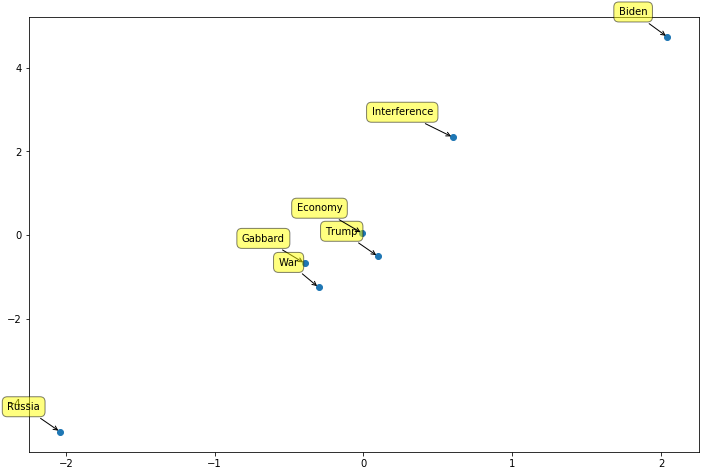

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.subplots_adjust(bottom = 0.1)
plt.figure(figsize = (12,8))
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
for label, x, y in zip(brands, coords[:, 0], coords[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

## Task E.
Use the location data collected in step A to find out lifts and sentiments regarding the candidates in three states – Michigan, Pennsylvania and Wisconsin (no need to treat them separately, call them “battleground” states). 

In [0]:
stateslist = ["MICHIGAN","PENNSYLVANIA","WISCONSIN",", MI",", PA",", WI",\
              "Lansing","Detroit","Madison","Pittsburg","Philadelphia"]

statestweets = flitered_tweets.copy()
statestweets['location'] = statestweets['location'].astype(str)

indexes = []
for location in statestweets['location']:
    state = [val for val in stateslist if val in location.upper()]
    if(state!=[]):
        indexes.extend(statestweets[statestweets['location']==location].index)
        
indexnp = np.array(indexes)
indexunique = np.unique(indexnp)
indexunique

array([  21,   55,  104,  220,  267,  316,  329,  346,  371,  386,  489,
        505,  517,  567,  614,  615,  639,  678,  727,  739,  809,  832,
        899,  988,  995, 1043, 1074, 1078, 1105, 1106, 1123, 1155, 1243,
       1271, 1275, 1280, 1359, 1372, 1377, 1381, 1418, 1482, 1538, 1566,
       1589, 1595, 1763, 1825, 1958, 2026, 2071, 2084, 2097, 2098, 2104,
       2111, 2158, 2170, 2207, 2243, 2248, 2307, 2348, 2350, 2483, 2512,
       2514, 2541, 2543, 2556, 2590, 2593, 2594, 2614, 2624, 2626, 2654,
       2777, 2908, 2917, 2918, 3013, 3037, 3134, 3446, 3471, 3496, 3558,
       3629, 3723, 3730, 3806, 3814, 3920, 3927, 3960, 4038, 4056, 4061,
       4073, 4075, 4131, 4145, 4162, 4234, 4244, 4249, 4277, 4291, 4363,
       4490, 4601, 4638, 4755, 4767, 4795, 4920, 4927, 4960, 5038, 5056,
       5061, 5073, 5075, 5131, 5145, 5162, 5234, 5244, 5249, 5277, 5291,
       5363, 5490, 5601, 5638, 5755, 5767, 5795, 5881, 5978, 6006, 6040,
       6041, 6081, 6094, 6191, 6212, 6284, 6307, 63

In [0]:
flitered_tweets = statestweets.ix[indexunique].copy()
flitered_tweets

C:\Users\rutwi\Anaconda_3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,location,Filtered_Tweet
21,"Downingtown, PA",maddowblog oh happy day cyber election masseus...
55,"Islamabad, Pakistan 🇵🇰",rt gpovanman takes great political gall claim ...
104,"NorthEastern Pennsylvania, USA",rt ewarren mark zuckerberg speech today shows ...
220,michigan,speakerpelosi stop slowrolling impeachment try...
267,"Lahore, Pakistan",turkey wins kurds stabbed us backed pkk asked ...
316,"Wisconsin, USA",yes america watching worthless career politici...
329,"Grand Rapids, MI",franklin graham saying many us bishops afraid ...
346,"Nevernever Land, PA",senatemajldr moscowmitch blocking nearly bills...
371,"Howell, MI",time make 8th congressional district red flip ...
386,"Michigan, USA",good chance michigan community said nahren anw...


In [0]:
countsdf = pd.DataFrame(flitered_tweets['Filtered_Tweet'].str.split(expand=True).stack().value_counts())

top2candidates = [['Trump',countsdf.loc[countsdf.index == 'trump',0:1].values[0][0]],\
                  ['Biden',countsdf.loc[countsdf.index == 'biden',0:1].values[0][0]],\
                  ['Gabbard',countsdf.loc[countsdf.index == 'gabbard',0:1].values[0][0]]]

top4issues = [['Russia',countsdf.loc[countsdf.index == 'russia',0:1].values[0][0]],\
              ['War',countsdf.loc[countsdf.index == 'war',0:1].values[0][0]],\
              ['Economy',countsdf.loc[countsdf.index == 'economy',0:1].values[0][0]],\
              ['Impeaching',countsdf.loc[countsdf.index == 'impeaching',0:1].values[0][0]]]

print("The issues we have chosen for our candidates in these States are:\n",top4issues)
print("\nThe Candidates we have chosen in these States are:\n",top2candidates)

The issues we have chosen for our candidates in these States are:
 [['Russia', 19], ['War', 10], ['Economy', 11], ['Impeaching', 10]]

The Candidates we have chosen in these States are:
 [['Trump', 54], ['Biden', 10], ['Gabbard', 13]]


In [0]:
issue_candidate = {}

for i in range(len(top4issues)): ## 4 issues
    for j in range(len(top2candidates)): ## 2 candidates
        issue_candidate[(top4issues[i][0],top2candidates[j][0])] = 0

tweet_issue_candidate_df = pd.DataFrame(columns = ['issue', 'candidate','tweet'],index=None)     
i = 0

for filtered_tweet in flitered_tweets['Filtered_Tweet']:   
    ## Counting the frequency of issue-candidate pairs
    for key in issue_candidate.keys():
        if (key[0].lower() in filtered_tweet and key[1].lower() in filtered_tweet):
            issue_candidate[key] += 1
            tweet_issue_candidate_df.loc[i] = [key[0],key[1],filtered_tweet]
            i+=1
    
print(issue_candidate)
print("\n")

### Lift analysis for Issue Pairs

lift_analysis = {}
for key in issue_candidate.keys():
   numerator = issue_candidate[key]
   denominator = dict(top4issues)[key[0]] * dict(top2candidates)[key[1]]
   lift_value = (numerator/denominator)*151 #len(flitered_tweets)
   lift_analysis[key] = lift_value
print(lift_analysis)
tweet_issue_candidate_df.head(10)

{('Russia', 'Trump'): 8, ('Russia', 'Biden'): 0, ('Russia', 'Gabbard'): 8, ('War', 'Trump'): 6, ('War', 'Biden'): 4, ('War', 'Gabbard'): 4, ('Economy', 'Trump'): 11, ('Economy', 'Biden'): 0, ('Economy', 'Gabbard'): 0, ('Impeaching', 'Trump'): 3, ('Impeaching', 'Biden'): 0, ('Impeaching', 'Gabbard'): 0}


{('Russia', 'Trump'): 1.1773879142300194, ('Russia', 'Biden'): 0.0, ('Russia', 'Gabbard'): 4.890688259109312, ('War', 'Trump'): 1.6777777777777778, ('War', 'Biden'): 6.04, ('War', 'Gabbard'): 4.6461538461538465, ('Economy', 'Trump'): 2.7962962962962963, ('Economy', 'Biden'): 0.0, ('Economy', 'Gabbard'): 0.0, ('Impeaching', 'Trump'): 0.8388888888888889, ('Impeaching', 'Biden'): 0.0, ('Impeaching', 'Gabbard'): 0.0}


,issue,candidate,tweet
0,War,Trump,turkey wins kurds stabbed us backed pkk asked ...
1,War,Trump,rt reuters democrat presidential candidate dec...
2,War,Biden,rt alchemistoxford sanders warren build big wa...
3,Economy,Trump,rt craigrozniecki barring turnout surge strong...
4,War,Biden,rt watchdogsniffer sanders warren build big wa...
5,War,Biden,sanders warren build big war chests biden fund...
6,War,Trump,rt jilevin war hands democrat slam trump https
7,War,Biden,rt phoenixwmn good bit reading learn tremendou...
8,Russia,Trump,rt veracitypak election campaign case russia h...
9,War,Trump,thinking difference warren trump kind shitty r...


In [0]:
tweet_issue_candidate_sentiment_df = \
tweet_issue_candidate_df.assign(overall_sentiment="",sentiment_score="")

sid_obj = SentimentIntensityAnalyzer() 

for index,rows in tweet_issue_candidate_sentiment_df.iterrows():
    tweet = rows['tweet']
    sentiment_dict = sid_obj.polarity_scores(str(tweet))
    score = sentiment_dict['compound']
    if score >= 0.05 : 
        sentiment = "Positive"
    elif score <= - 0.05 : 
        sentiment = "Negative"
    else:
        sentiment = "Neutral"
        
    tweet_issue_candidate_sentiment_df.loc[index]['sentiment_score'] = score
    tweet_issue_candidate_sentiment_df.loc[index]['overall_sentiment'] = sentiment

In [0]:
tweet_issue_candidate_sentiment_df

,issue,candidate,tweet,overall_sentiment,sentiment_score
0,War,Trump,turkey wins kurds stabbed us backed pkk asked ...,Negative,-0.0829
1,War,Trump,rt reuters democrat presidential candidate dec...,Negative,-0.5994
2,War,Biden,rt alchemistoxford sanders warren build big wa...,Negative,-0.7506
3,Economy,Trump,rt craigrozniecki barring turnout surge strong...,Positive,0.6486
4,War,Biden,rt watchdogsniffer sanders warren build big wa...,Negative,-0.7506
5,War,Biden,sanders warren build big war chests biden fund...,Negative,-0.7506
6,War,Trump,rt jilevin war hands democrat slam trump https,Negative,-0.7579
7,War,Biden,rt phoenixwmn good bit reading learn tremendou...,Positive,0.3182
8,Russia,Trump,rt veracitypak election campaign case russia h...,Neutral,0
9,War,Trump,thinking difference warren trump kind shitty r...,Negative,-0.0516


In [0]:
tweet_issue_candidate_sentiment_df['sentiment_score'] = tweet_issue_candidate_sentiment_df['sentiment_score'].astype(float)
sum_df = tweet_issue_candidate_sentiment_df.groupby(['issue','candidate'])['sentiment_score'].sum()
sentimentdf = pd.DataFrame(sum_df)
sentimentdf

sentiment_score
issue      candidate                 
Economy    Trump               7.0176
Impeaching Trump               0.0000
Russia     Gabbard            -0.1147
           Trump               1.5845
War        Biden              -1.9336
           Gabbard            -1.0564
           Trump              -1.3374

## Task E. Part 2

In [0]:
master_list = []
i =0
for comment in taskedf['combined']:
    
    #break sentence to words
    words = word_tokenize(str(comment))
    
    #Lower case
    words = [word.lower() for word in words]
    
    #Remove single-character tokens (mostly punctuation)
    words = [word for word in words if len(word) > 1]
  
    #Remove special character sequences like ...,''''''
    words = [word for word in words if word.isalnum()]
    
    #Replace words
    for word in words:
        my_word = re.sub('[^a-zA-Z0-9 \n\.]', '', word)
        if my_word in df_replacements['word'].values:
            words[words.index(word)] = df_replacements[df_replacements['word']==word]['replacement'].values[0] 
      
    #Remove numbers
    words = [word for word in words if not word.isnumeric()]
    
    #Remove duplicates (we want to count frequency of a word as 1 even if it has been used more than once in a single comment)
    unique_words = []
    [unique_words.append(word) for word in words if word not in unique_words]   
    
    #Remove stop words
    stop_words=set(stopwords.words("english"))
    filtered_words = []
    for word in unique_words:
        if word not in stop_words:
            filtered_words.append(word)
    
    master_list.extend(filtered_words)
    flitered_tweets.loc[i,'Filtered_Tweet'] = ' '.join(filtered_words)
    i=i+1
wordfreq = FreqDist(master_list)
wordfreq

FreqDist({'https': 2611, 'rt': 2061, 'nan': 1850, 'election': 1627, 'us': 1411, 'trump': 1284, 'usa': 811, 'democrat': 687, 'gabbard': 512, 'russia': 385, ...})

In [0]:
taskefreqdf = pd.DataFrame(wordfreq.most_common(), columns =['Word', 'Count'])
taskefreqdf

top2candidates = [['Trump',taskefreqdf[taskefreqdf['Word']=='trump']['Count'].values[0]],\
                  ['Biden',taskefreqdf[taskefreqdf['Word']=='biden']['Count'].values[0]],\
                  ['Gabbard',taskefreqdf[taskefreqdf['Word']=='gabbard']['Count'].values[0]]]


top4issues = [['Battleground1',taskefreqdf[taskefreqdf['Word']=='battleground1']['Count'].values[0]]]

print("The issues we have chosen for our candidates in these States are:\n",top4issues)
print("\nThe Candidates we have chosen in these States are:\n",top2candidates)

The issues we have chosen for our candidates in these States are:
 [['Battleground1', 359]]

The Candidates we have chosen in these States are:
 [['Trump', 1284], ['Biden', 267], ['Gabbard', 512]]


In [0]:
issue_candidate = {}

for i in range(len(top4issues)): ## 4 issues
    for j in range(len(top2candidates)): ## 2 candidates
        issue_candidate[(top4issues[i][0],top2candidates[j][0])] = 0

tweet_issue_candidate_df = pd.DataFrame(columns = ['issue', 'candidate','tweet'],index=None)     
i = 0

for filtered_tweet in flitered_tweets['Filtered_Tweet']:   
    ## Counting the frequency of issue-candidate pairs
    for key in issue_candidate.keys():
        if (key[0].lower() in filtered_tweet and key[1].lower() in filtered_tweet):
            issue_candidate[key] += 1
            tweet_issue_candidate_df.loc[i] = [key[0],key[1],filtered_tweet]
            i+=1
    
print(issue_candidate)
print("\n")

### Lift analysis for Issue Pairs

lift_analysis = {}
for key in issue_candidate.keys():
   numerator = issue_candidate[key]
   denominator = dict(top4issues)[key[0]] * dict(top2candidates)[key[1]]
   lift_value = (numerator/denominator)* len(taskefreqdf)
   lift_analysis[key] = lift_value
print(lift_analysis)
tweet_issue_candidate_df.head(10)

{('Battleground1', 'Trump'): 84, ('Battleground1', 'Biden'): 59, ('Battleground1', 'Gabbard'): 19}


{('Battleground1', 'Trump'): 1.3388436206492593, ('Battleground1', 'Biden'): 4.5222684736002, ('Battleground1', 'Gabbard'): 0.7594500783426184}


,issue,candidate,tweet
0,Battleground1,Trump,mba tulane voter rt vanidapeters pollster anxi...
1,Battleground1,Trump,battleground1 leeholly81 trump marklevinshow s...
2,Battleground1,Trump,battleground1 usa rt reuters democrat presiden...
3,Battleground1,Biden,working home sanders battleground1 build big w...
4,Battleground1,Biden,west chester rt alchemistoxford sanders battle...
5,Battleground1,Biden,blogosphere rt guardianus sanders battleground...
6,Battleground1,Biden,texas list stated michelle would take percent ...
7,Battleground1,Biden,united states rt janetsgoodnews sanders battle...
8,Battleground1,Biden,frackville battleground1 joerogan petition bid...
9,Battleground1,Biden,los angeles ca sanders battleground1 build big...


In [0]:
tweet_issue_candidate_sentiment_df = \
tweet_issue_candidate_df.assign(overall_sentiment="",sentiment_score="")

sid_obj = SentimentIntensityAnalyzer() 

for index,rows in tweet_issue_candidate_sentiment_df.iterrows():
    tweet = rows['tweet']
    sentiment_dict = sid_obj.polarity_scores(str(tweet))
    score = sentiment_dict['compound']
    if score >= 0.05 : 
        sentiment = "Positive"
    elif score <= - 0.05 : 
        sentiment = "Negative"
    else:
        sentiment = "Neutral"
        
    tweet_issue_candidate_sentiment_df.loc[index]['sentiment_score'] = score
    tweet_issue_candidate_sentiment_df.loc[index]['overall_sentiment'] = sentiment

In [0]:
tweet_issue_candidate_sentiment_df.head(10)

,issue,candidate,tweet,overall_sentiment,sentiment_score
0,Battleground1,Trump,mba tulane voter rt vanidapeters pollster anxi...,Negative,-0.1779
1,Battleground1,Trump,battleground1 leeholly81 trump marklevinshow s...,Positive,0.5719
2,Battleground1,Trump,battleground1 usa rt reuters democrat presiden...,Negative,-0.5994
3,Battleground1,Biden,working home sanders battleground1 build big w...,Negative,-0.6486
4,Battleground1,Biden,west chester rt alchemistoxford sanders battle...,Negative,-0.7506
5,Battleground1,Biden,blogosphere rt guardianus sanders battleground...,Negative,-0.7506
6,Battleground1,Biden,texas list stated michelle would take percent ...,Neutral,0.0000
7,Battleground1,Biden,united states rt janetsgoodnews sanders battle...,Negative,-0.5574
8,Battleground1,Biden,frackville battleground1 joerogan petition bid...,Neutral,0.0000
9,Battleground1,Biden,los angeles ca sanders battleground1 build big...,Negative,-0.7506


In [0]:
tweet_issue_candidate_sentiment_df['sentiment_score'] = tweet_issue_candidate_sentiment_df['sentiment_score'].astype(float)
sum_df = tweet_issue_candidate_sentiment_df.groupby(['issue','candidate'])['sentiment_score'].sum()
sentimentdf = pd.DataFrame(sum_df)
sentimentdf

sentiment_score
issue         candidate                 
Battleground1 Biden             -22.7853
              Gabbard            -1.0342
              Trump              23.6534

<img src='battlegrounds-lifts.png'>

## Task F. 
What advice would you give to each of the two candidates above based on your analyses in C, D and E above?

<b>Advice to Trump:</b><br>
1. The lift score for Trump and the economy is high (3.00) and he is the only candidate who has any kind of association with the economy. Furthermore, people associate economy and Trump in a very positive sentiment (score is 15.34). Thus, we would recommend him to continue talking about the economy to bolster this positive sentiments. 

2. There is a high association between the issue of war and Trump (3.56); people have an extremely negative sentiment (-65.47) about the association, which is the most negative sentiment score we have observed. We would strongly advise Trump to stop mentioning war and related topics in speeches or tweets because people are unhappy about the idea of war. 

3. Also, there is a positive sentiment between Trump and Russia (26.39), which is the most positive sentiment score we observed. This is combined with the fact people associate him with Russia a lot already (lift is 1.47). He can leverage this fact and the very high sentiment score to engage more with his supporters and potential voters.

4. According to our analysis regarding battleground locations, we learned that the association between the people from those states and Trump is relevant (lift is 1.34) and the sentiment score is extremely positive (23.65). Evidently, Trump has favorable connections with voters from these three battleground states. Moreover, he is the only candidate to have both a strong association and a positive sentiment score with battleground states. Therefore, we would encourage Trump to captialize on this and continue to spend efforts on campaigning in cities within these states. 

<b>Advice to Gabbard:</b><br>
1. Congresswoman Tulsi Gabbard should stop speaking about topics like war because there is a negative sentiment associated between Gabbard and this issue. The lift is 7.66 which is the highest value among all the candidates and the all issue. Also, the sentiment is -3.27 which reinforces the previous idea that people are not favorable of war.

2. The lift between Gabbard and Russia is considerably high (4.71) and the sentiment score for the two is also positive (2.43). Thus, it would benefit Gabbard to talk more about Russia and related topics because her stance on these issues is highly favorable.

3. Also, for better or worse, Gabbard is highly associated with Vice President Joe Biden. It is up to the Congresswoman’s campaign if they want to differentiate themselves from Biden based on how different their policies are. 

4. In addition, the association between Gabbard and the economy is 0 which means no one is mentioning the two together. We would strongly suggest Gabbard to talk more about her plans to improve the economy, job creation, etc.

5. According to our analysis regarding battleground locations, we learned that the association between the people from those states and Gabbard is negligible (lift is 0.76) and thus the sentiment score is irrelevant; the score is negative (-1.03). Evidently, Gabbard has very little name recognition with voters from these three battleground states. Therefore overall, we would encourage Gabbard to captialize on her recent spike in popularity and begin to spend bigger efforts on campaigning in cities within these states. 


<b>Advice to Biden:</b><br>
1. There is a high association between the issue of war and Biden (3.76); people have an extremely negative sentiment (-29.67) about the association, which is the second most negative sentiment score we have observed. We would strongly advise Biden to stop mentioning war and related topics in speeches or tweets because people are unhappy about the idea of war. 

2. In addition, the association between Biden and the economy is 0 which means no one is mentioning the two together. We would strongly suggest Biden to talk more about his plans to improve the economy, job creation, etc.

3. Again, the two candidates Biden and Gabbard are associated with each other (their lift is 2.67). It is up to the Vice President’s campaign if they want to differentiate themselves from Gabbard based on how different their policies are. 

4. Currently, Biden does not have a positive sentiment score on any of the issues we identified. Perhaps, Biden can work with his campaign to highlight important achievements from his career and his optimistic plans for the country’s future so that voters can begin to associate him in a more positive note. 

5. According to our analysis regarding battleground locations, we learned that the association between the people from those states and Biden is very strong (lift is 4.52) and the sentiment score is extremely negative (-22.78). Evidently, Biden has very unfavorable connections with voters from these three battleground states. Moreover, he is the one candidate to have both a strong association and very low sentiment score with battleground states. This is concerning for Biden's campaign because Trump apparently has a very positive sentiment score in these states. Therefore, we would encourage Biden to step up his efforts and increase spending when it comes to campaigning in battleground states. 